In [1]:
import numpy as np
import soundfile as sf
from beamformer import delaysum as ds
from beamformer import util
import glob
import os
from pathlib import Path
from IPython.display import Audio
import torch
import matplotlib.pyplot as plt

SAMPLING_FREQUENCY = 16000
FFT_LENGTH = 512
FFT_SHIFT = 256
ENHANCED_WAV_NAME = './output/enhanced_speech_delaysum.wav'
MIC_ANGLE_VECTOR = np.arange(8, dtype="float32") * (360 / 8)+7
print(MIC_ANGLE_VECTOR)
LOOK_DIRECTION = 135
MIC_DIAMETER = 0.15

[  7.  52.  97. 142. 187. 232. 277. 322.]


In [3]:
meeting_folder="/Users/ccui/Desktop/DATA/AMI_sample/amicorpus/ES2009a"
wavs = glob.glob(os.path.join(meeting_folder, "audio/*"))
array1_list = []
array1_list_torch = []
# wav_multi = np.zeros((len(wav), len(channel_index_vector)), dtype=np.float32)
for wav in wavs:
    mic_type = Path(wav).stem.split(".")[-1].split("-")[0]
    if mic_type in ["Array1"]:
        # array_path_list.append(str(Path(wav)))
        array, fs = sf.read(
        str(Path(wav)),
        dtype="float32",
        )
        # print(array.shape)
        array=array[16000*9:16000*15]
        array1_list_torch.append(torch.from_numpy(array).unsqueeze(0))
        array = array[..., np.newaxis]
        array1_list.append(array)
array1_list=np.concatenate(array1_list, axis=1)
print(array1_list.shape)
array1_list_torch=torch.cat(array1_list_torch, 0).float()


(96000, 8)


In [4]:
def get_enhenced(LOOK_DIRECTION):
    multi_channels_data = array1_list

    complex_spectrum, _ = util.get_3dim_spectrum_from_data(multi_channels_data, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)

    ds_beamformer = ds.delaysum(MIC_ANGLE_VECTOR, MIC_DIAMETER, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)
    # print(complex_spectrum.shape)
    beamformer = ds_beamformer.get_sterring_vector(LOOK_DIRECTION)
    print(beamformer.shape)

    enhanced_speech = ds_beamformer.apply_beamformer(beamformer, complex_spectrum)
    return enhanced_speech
enhanced_speech=get_enhenced(135)

AttributeError: module 'scipy.signal' has no attribute 'hanning'

In [6]:
def get_enhenced_3D(azimuth,elevation):
    multi_channels_data = array1_list

    complex_spectrum, _ = util.get_3dim_spectrum_from_data(multi_channels_data, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)

    ds_beamformer = ds.delaysum(MIC_ANGLE_VECTOR, MIC_DIAMETER, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)
    # print(complex_spectrum.shape)
    beamformer = ds_beamformer.get_sterring_vector_3D(azimuth,elevation)
    print(beamformer.shape)

    enhanced_speech = ds_beamformer.apply_beamformer(beamformer, complex_spectrum)
    return enhanced_speech
enhanced_speech=get_enhenced_3D(135,45)

In [4]:
def get_enhenced_3D_integ(azimuth_list,elevation_list):
    multi_channels_data = array1_list

    complex_spectrum, _ = util.get_3dim_spectrum_from_data(multi_channels_data, FFT_LENGTH, FFT_SHIFT, FFT_LENGTH)

    ds_beamformer = ds.delaysum(MIC_ANGLE_VECTOR, MIC_DIAMETER, sampling_frequency=SAMPLING_FREQUENCY, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT)
    enhanced_speech=np.ones((complex_spectrum.shape[1], complex_spectrum.shape[2]), dtype=np.complex64)

    for azimuth in azimuth_list:
        for elevation in elevation_list:
            beamformer = ds_beamformer.get_sterring_vector_3D(azimuth,elevation)
            enhanced_speech += ds_beamformer.apply_beamformer_direction(beamformer, complex_spectrum)
    enhanced_speech=enhanced_speech/(len(azimuth_list)+len(elevation_list))
    enhenced_spec=util.spec2wav(enhanced_speech, SAMPLING_FREQUENCY, FFT_LENGTH, FFT_LENGTH, FFT_SHIFT) 
    return enhenced_spec

enhanced_speech=get_enhenced_3D_integ(range(0,360,45),range(30,45,5))

In [7]:
# enhanced_speech=get_enhenced(135)
Audio(data=enhanced_speech, rate=16000)

In [52]:
enhanced_speech=get_enhenced(120)
Audio(data=enhanced_speech, rate=16000)

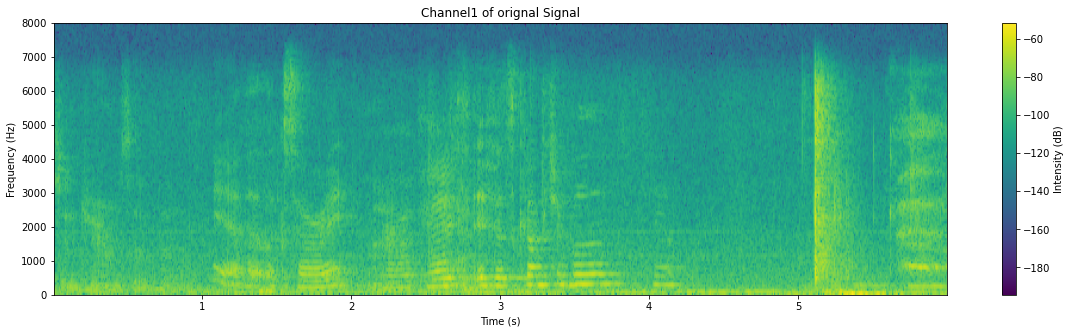

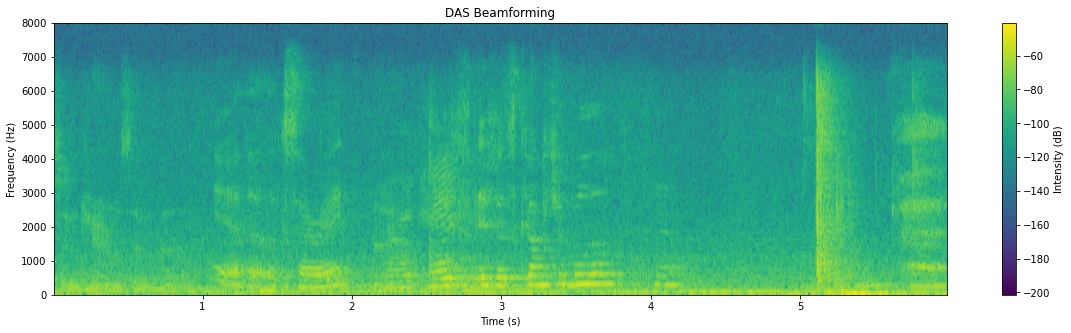

In [6]:
def get_spect(signal,title, vmin=-200, vmax=-60):
    plt.figure(figsize=(20, 5)) 
    # Compute the spectrogram
    Sxx, frequencies ,_,_ = plt.specgram(signal, Fs=16000)
    # mask=frequencies>0
    # Sxx_masked = Sxx[mask, :]
    # sxx=10 * np.log10(Sxx)
    # # norm = Normalize(vmin=-150, vmax=-60)
    # # plt.imshow(sxx, aspect='auto', cmap='inferno', vmin=-150, vmax=-60)
    # plt.imshow(sxx, aspect='auto', cmap='inferno', vmin=vmin, vmax=vmax)
    # plt.gca().invert_yaxis()
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.colorbar(label="Intensity (dB)")
    plt.show()
get_spect(array1_list_torch[0],"Channel1 of orignal Signal")
# get_spect(beamformed_array1,"GCC-Phat Beamforming")
get_spect(enhanced_speech,"DAS Beamforming")

In [60]:
enhanced_speech_8mic=get_enhenced_integral((range(0,360,45)))
Audio(data=enhanced_speech_8mic, rate=16000)

In [55]:
enhanced_speech_integral=get_enhenced_integral(range(360))
Audio(data=enhanced_speech_integral, rate=16000)

In [56]:
print(len(range(0,360,60)))

6


In [57]:
enhanced_speech_4=get_enhenced_integral(range(0,360,60))
Audio(data=enhanced_speech_4, rate=16000)

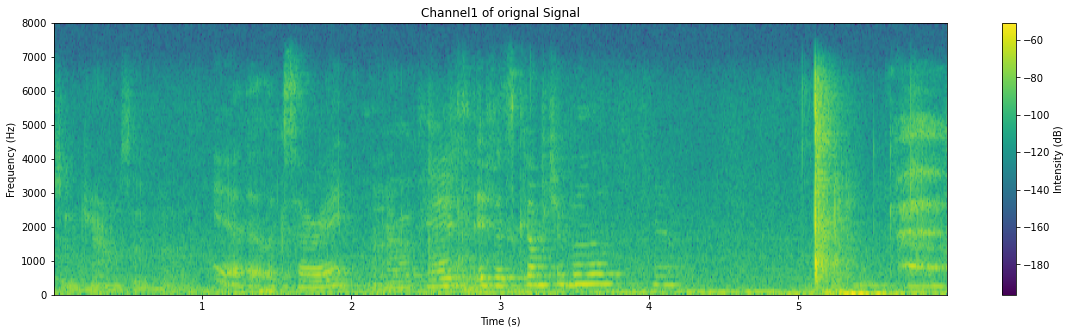

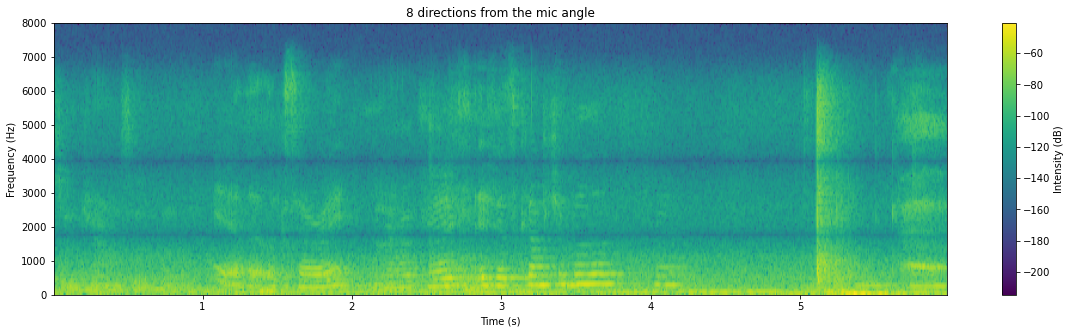

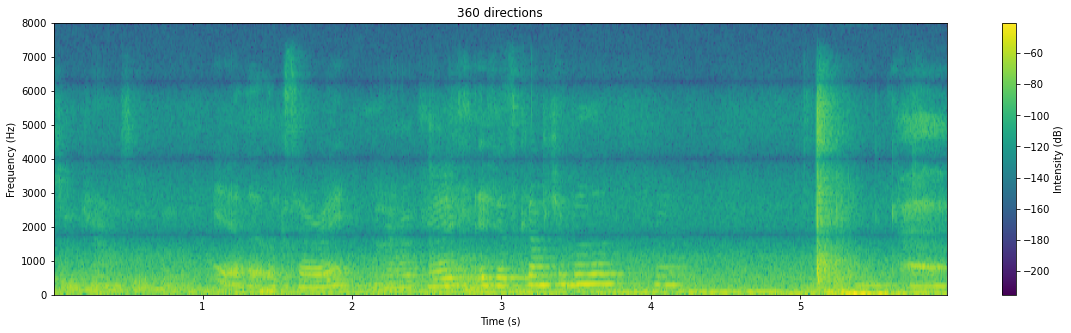

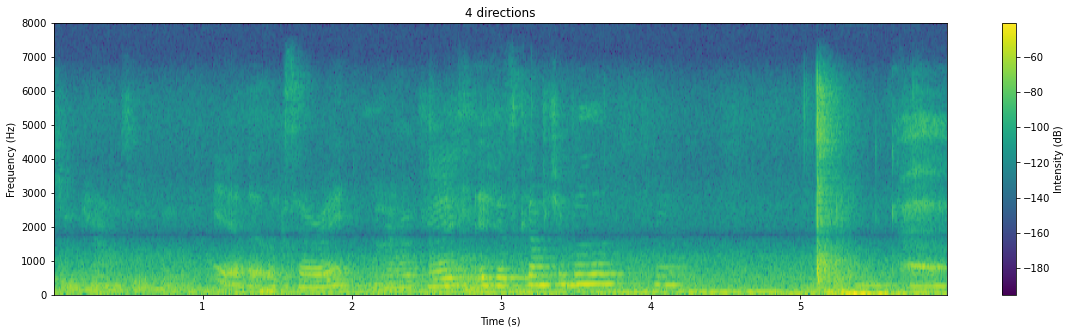

In [61]:
get_spect(array1_list_torch[7],"Channel1 of orignal Signal", vmin=-150, vmax=-50)
get_spect(enhanced_speech_8mic,"8 directions from the mic angle", vmin=-150, vmax=-50)
get_spect(enhanced_speech_integral,"360 directions", vmin=-150, vmax=-50)
get_spect(enhanced_speech_4,"4 directions", vmin=-150, vmax=-50)

In [103]:
### enhencement

In [104]:
import torchaudio
from speechbrain.pretrained import WaveformEnhancement

enhance_model = WaveformEnhancement.from_hparams(
    source="speechbrain/mtl-mimic-voicebank",
    savedir="pretrained_models/mtl-mimic-voicebank",
)


In [107]:
enhanced = enhance_model.enhance_batch(torch.from_numpy(enhanced_speech_8mic).unsqueeze(0))


In [108]:
Audio(data=enhanced, rate=16000)

In [112]:
enhanced = enhance_model.enhance_batch(torch.from_numpy(enhanced_speech_integral).unsqueeze(0))
Audio(data=enhanced, rate=16000)

In [113]:
enhanced = enhance_model.enhance_batch(array1_list_torch)
Audio(data=enhanced, rate=16000)

In [116]:
enhanced_speech_8mic=get_enhenced_integral(MIC_ANGLE_VECTOR,enhanced.numpy())
Audio(data=enhanced_speech_8mic, rate=16000)

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [6]:
a = np.array([1,2,3])
print(a, a.shape)
print(a.T,a.T.shape)

[1 2 3] (3,)
[1 2 3] (3,)


In [13]:
b=np.arange(24).reshape(3,8)
print(b)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]]


In [16]:
print(np.matmul(a.T,b))

[ 64  70  76  82  88  94 100 106]


In [5]:
b=torch.rand(10)-0.5
print(b)

tensor([-0.3251,  0.0246, -0.4852,  0.4049,  0.3454,  0.1587,  0.1199,  0.2621,
         0.4930,  0.1984])


In [6]:
print(np.linspace(-89.5, 89.5, 180))

[-89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 -81.5 -80.5 -79.5 -78.5
 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5
 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5
 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5
 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5
 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5
 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5
  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5   4.5   5.5
   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5  15.5  16.5  17.5
  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5  27.5  28.5  29.5
  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5  38.5  39.5  40.5  41.5
  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5  50.5  51.5  52.5  53.5
  54.5  55.5  56.5  57.5  58.5  59.5  60.5  61.5  62.5  63.5  64.5  65.5
  66.5  67.5  68.5  69.5  70.5  71.5  72.5  73.5  7